<h2>Расшифровка данных таблицы</h2>
<ol>
<li>Дата и время: Временной интервал в десять минут.</li>
<li>Температура: Температура погоды.</li>
<li>Влажность: Влажность воздуха.</li>
<li>Скорость ветра: Скорость ветра.</li>
<li>Общие сведения Диффузные потоки: “Диффузный поток” - это общий термин для описания низкотемпературных (от < 0,2° до ~ 100°C) флюидов, которые медленно вытекают через сульфидные насыпи, трещиноватые потоки лавы и скопления бактериальных матов и макрофауны.</li>
<li>Рассеянные потоки</li>
<li>Зона 1 Энергопотребления</li>
<li>Зона 2 энергопотребления</li>
<li>Зона 3 энергопотребления</li>
</ol>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/Users/ilya/Desktop/projects/TimeSeriesReasearch/powerconsumption.csv')
data.head()
# Преобразуем дату в формат datetime и установим индекс
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)
data_copy = data.drop(columns=['PowerConsumption_Zone2', 'PowerConsumption_Zone3'])
# Нормализуем данные
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['PowerConsumption_Zone1', 'PowerConsumption_Zone2']))

# Преобразуем обратно в DataFrame для удобства
scaled_data = pd.DataFrame(scaled_data, columns=data_copy.columns, index=data_copy.index)

# Разделим на входные признаки (X) и целевую переменную (y)
X = scaled_data
y = scaled_data['PowerConsumption_Zone1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [49]:
SEQ_LENGTH = 6
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.seq_length = seq_length
        self.forecast_period = 1

    def __len__(self):
        return len(self.X) - self.seq_length-self.forecast_period

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.seq_length]
        y_seq = self.y[idx + self.seq_length+self.forecast_period]
        return X_seq, y_seq

# Создаем датасеты
train_dataset = TimeSeriesDataset(X_train, y_train, SEQ_LENGTH)
test_dataset = TimeSeriesDataset(X_test, y_test, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, hidden_size*2),
                                nn.ReLU(),
                                nn.Linear(hidden_size*2, output_size))

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # берем последний временной шаг
        return out

In [ ]:
cinput_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1

model = TiDE(input_size, hidden_size, output_size).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [51]:
# Обучение модели
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}")


Epoch 1/10, Loss: 0.0135
Epoch 2/10, Loss: 0.0010
Epoch 3/10, Loss: 0.0009
Epoch 4/10, Loss: 0.0008
Epoch 5/10, Loss: 0.0008
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0007
Epoch 8/10, Loss: 0.0007
Epoch 9/10, Loss: 0.0007
Epoch 10/10, Loss: 0.0007


In [52]:
# Оценка модели
model.eval()
test_loss = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        test_loss.append(loss.item())
        
print(f'Test loss {sum(test_loss)/len(test_loss)}')

Test loss 0.0007475345827093939


In [53]:
BATCH_SIZE = 1
# Сохраним предсказания и реальные значения
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(X_batch)
        
        # Сохраняем предикты и метки
        all_preds.append(y_pred.cpu().numpy())
        all_true.append(y_batch.cpu().numpy())

# Преобразуем списки в массивы
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Обратное масштабирование для предсказаний
all_preds_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((all_preds.shape[0], scaled_data.shape[1] - 1)), all_preds], axis=1)
)[:, -1]  # берем колонку с предсказаниями

# Обратное масштабирование для истинных значений
all_true_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((all_true.shape[0], scaled_data.shape[1] - 1)), all_true.reshape(-1, 1)], axis=1)
)[:, -1]  # берем колонку с истинными значениями


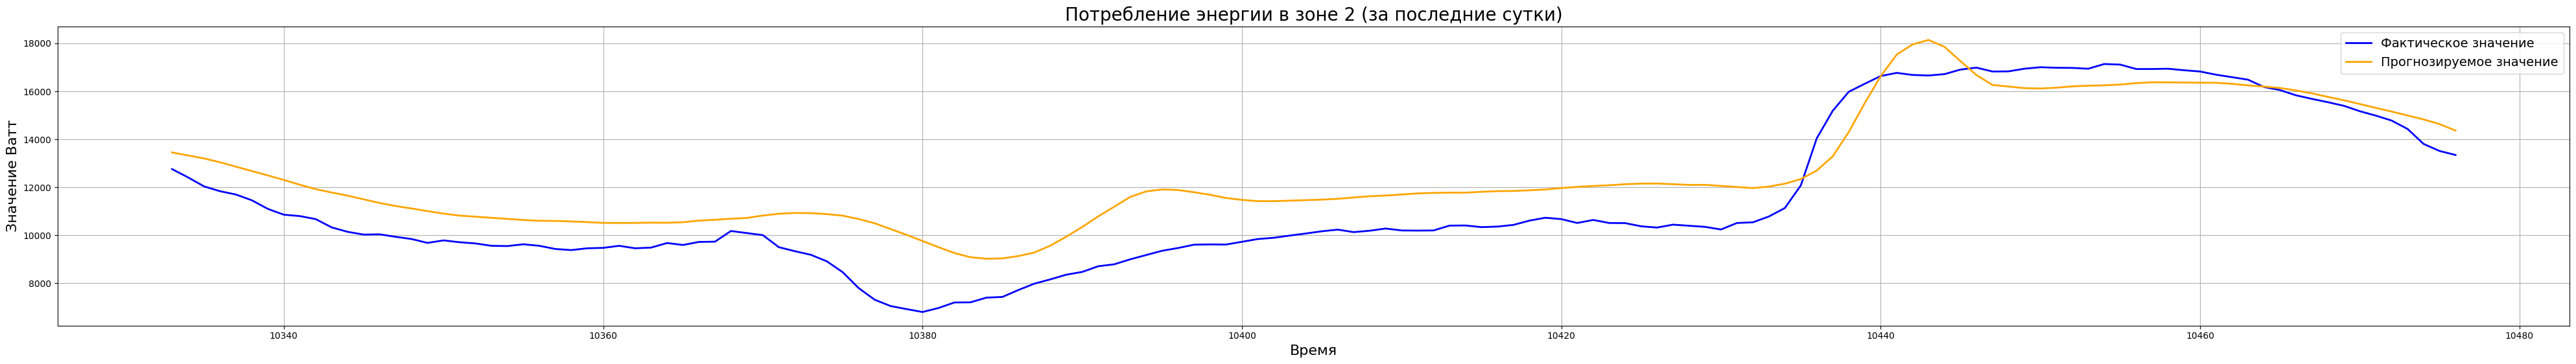

In [54]:
plt.figure(figsize=(50, 6))
plt.plot(range(len(all_preds_rescaled))[-144:], all_true_rescaled[-144:], label='Фактическое значение', color='blue', linewidth=2)
plt.plot(range(30, len(all_preds_rescaled))[-144:], all_preds_rescaled[-144:], label='Прогнозируемое значение', color='orange', linewidth=2)

# Подписи
plt.title("Потребление энергии в зоне 2 (за последние сутки)", fontsize=20)
plt.xlabel("Время", fontsize=16)
plt.ylabel("Значение Ватт", fontsize=16)

# Легенда
plt.legend(fontsize=14)

# Сетка для удобства анализа
plt.grid(True)

plt.show()


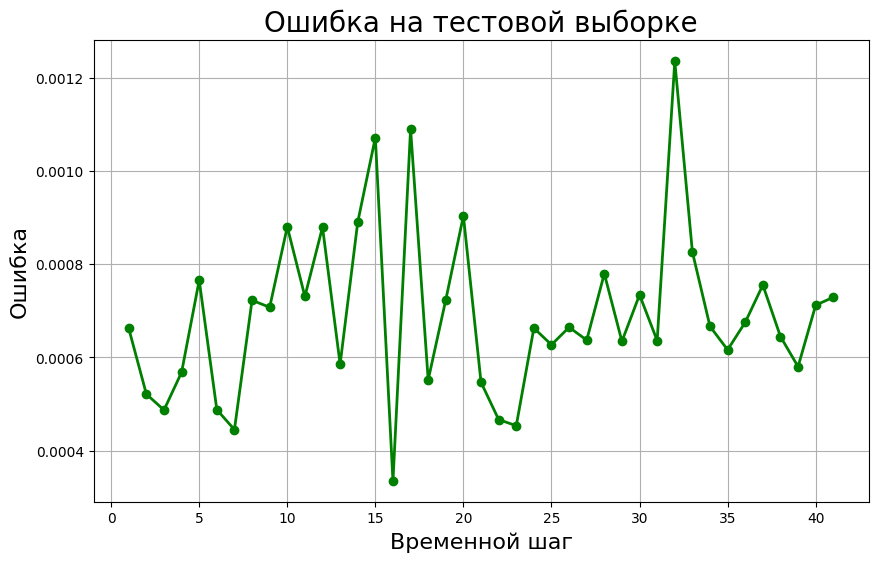

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_loss) + 1), test_loss, marker='o', linestyle='-', color='green', linewidth=2)

# Подписи
plt.title("Ошибка на тестовой выборке", fontsize=20)
plt.xlabel("Временной шаг", fontsize=16)
plt.ylabel("Ошибка", fontsize=16)

# Сетка для удобства анализа
plt.grid(True)

plt.show()
